# Water Balance Project
1. Display soil moisture data. 
We have 135 soil moisture files. Each file has a time dimension equal to 1, so I presume one per month. Each file has 6 depths for soil moisture readings. And then each file has 4 lat and 6 long locations.

In [170]:
# Import requiried packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import netCDF4 as nc
from netCDF4 import MFDataset
from pathlib import Path
from pyproj import CRS
import contextily as cx
import xarray as xr
import dask
import pynhd as nhd
import pandas as pd
from geopandas import GeoSeries
import regionmask as rm
from shapely.geometry import box, Point, Polygon
import pygeoogc as geoogc
import pygeoutils as geoutils
import hydrodata as hd
import contextily as cx
import folium
import rioxarray
import geopandas
from shapely.geometry import box, mapping

# for plotting
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

## Open all files at once and load them into a single xarray dataset
xr.open_mfdataset() will read all the files indicated by the wildcard. It will even parse the time axis correctly so that the time slices are in the right order.
http://xarray.pydata.org/en/stable/io.html#netcdf

In [177]:
#Preparation of the data
SM_data=xr.open_mfdataset('/home/jovyan/data/whw2020_waterbalance/data/SoilMoistureData/*.nc4')
SM_data['SOILM'].to_netcdf('Combined_SOILM_monthly_Data.nc')
SM_data=xr.open_dataarray('Combined_SOILM_monthly_Data.nc')
SM_data

<xarray.DataArray 'SOILM' (time: 66, depth: 6, lat: 6, lon: 18)>
array([[[[500.8323, ..., 323.9491],
         ...,
         [628.6147, ..., 209.4659]],

        ...,

        [[250.06  , ..., 162.19  ],
         ...,
         [274.48  , ...,  99.7   ]]],


       ...,


       [[[369.5453, ..., 304.4573],
         ...,
         [552.8285, ..., 237.6797]],

        ...,

        [[186.44  , ..., 187.91  ],
         ...,
         [275.38  , ..., 124.02  ]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 46.06 46.19 46.31 46.44 46.56 46.69
  * depth    (depth) float64 100.0 50.0 5.0 25.0 70.0 150.0
  * lon      (lon) float64 -121.2 -121.1 -120.9 -120.8 ... -119.3 -119.2 -119.1
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2020-06-01
Attributes:
    long_name:      Soil moisture content
    units:          kg/m^2
    code:           86
    table:          130
    original_name:  var86

## Sum the soil moisture with depth
We store the output in a new data array called total_sm and we sum along the depth dimension

In [179]:
SM_data['total_sm']=ds.SOILM.sum(dim='depth')

In [180]:
SM_data

,Array,Chunk
Bytes,28.51 kB,432 B
Shape,"(66, 6, 18)","(1, 6, 18)"
Count,794 Tasks,66 Chunks
Type,float32,numpy.ndarray


## Plot the soil moisture data (July 2020)

In [163]:
ly_huc08code = '17030003'

In [164]:
ly_bbox = gpd.GeoSeries(box(*ly_huc10_gdf.total_bounds), crs=ly_huc10_gdf.crs)

In [165]:
# Extract the outer bounding box coordinates of watershed (CRS= EPSG:3857)
ly_bbox = gpd.GeoSeries(box(*ly_gdf.total_bounds), crs=ly_gdf.crs)

In [166]:
ly_lon_slice = slice(ly_bbox.bounds.minx[0], ly_bbox.bounds.maxx[0])
ly_lat_slice = slice(ly_bbox.bounds.miny[0], ly_bbox.bounds.maxy[0])

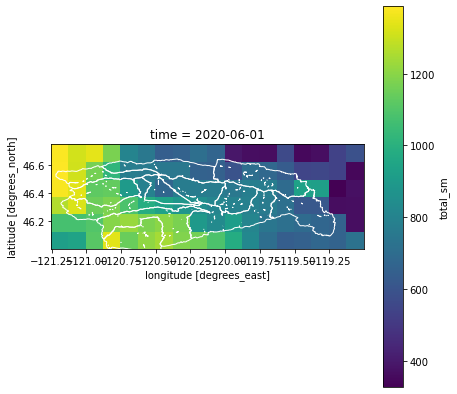

In [167]:
f, ax = plt.subplots(1, figsize=(7,7))
ds.total_sm.isel(time=-1).plot(ax=ax)
ly_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

# Clip data to watershed

In [168]:
#Shape file bounds
basin_shape_file_path='./data/HUC8_GCS/HUC8-17030003_gcs.shp'
shape_file=gpd.read_file(basin_shape_file_path) # import basin boundary (Shape file in CRS: EPSG:4326)

#bounding box for data downloading
resolution=0.1   #Resolution of IMERG data
min_lat, max_lat, min_lon, max_lon = shape_file.bounds.miny[0]-resolution/2, shape_file.bounds.maxy[0]+resolution/2, shape_file.bounds.minx[0]-resolution/2, shape_file.bounds.maxx[0]+resolution/2
print(min_lon, min_lat, max_lon, max_lat)

-121.26903696684327 45.93282389319888 -119.15510656613446 46.696448636806146


In [181]:
#Get Data Spatial Resolution
resolution=(abs(SM_data['total_sm'][0,0,0].lat-SM_data['total_sm'][1,1,1].lat)).values
print(resolution)

sliced_data=SM_data['total_sm'].copy()
print("shape of the sliced data is", sliced_data.shape)
print(sliced_data)
shape=sliced_data.shape

########################################Extract data within a Shape file#######################
for i in range (shape[1]):
    for j in range (shape[2]):
        
        lon_cent, lat_cent = sliced_data[0, i, j].lon.values, sliced_data[0, i, j].lat.values
        
        lon1, lat1 = lon_cent-resolution/2, lat_cent-resolution/2
        lon2, lat2 = lon_cent-resolution/2, lat_cent+resolution/2
        lon3, lat3 = lon_cent+resolution/2, lat_cent-resolution/2
        lon4, lat4 = lon_cent+resolution/2, lat_cent+resolution/2
        
        grid_poly = gpd.GeoDataFrame({'geometry': GeoSeries(Polygon([(lon1, lat1), (lon3, lat3),  (lon4, lat4), (lon2, lat2)]))})
        
        try:
            intersect_poly = gpd.overlay(shape_file, grid_poly, how='intersection')
            if len(intersect_poly)==0:
                sliced_data[:, i, j]=np.nan
        except:
            sliced_data[:, i, j]=np.nan
            continue
            
sliced_data.to_netcdf('Total_SOILM_monthly_Data_catchment.nc')

0.125
shape of the sliced data is (66, 6, 18)
<xarray.DataArray 'total_sm' (time: 66, lat: 6, lon: 18)>
dask.array<sum-aggregate, shape=(66, 6, 18), dtype=float32, chunksize=(1, 6, 18), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 46.06 46.19 46.31 46.44 46.56 46.69
  * lon       (lon) float64 -121.2 -121.1 -120.9 -120.8 ... -119.3 -119.2 -119.1
  * time      (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2020-06-01
    total_sm  (time, lat, lon) float32 dask.array<chunksize=(1, 6, 18), meta=np.ndarray>


TypeError: this variable's data is stored in a dask array, which does not support item assignment. To assign to this variable, you must first load it into memory explicitly using the .load() method or accessing its .values attribute.

In [ ]:
#Plot the monthly data for shp
%matplotlib inline
sliced_data[0,:,:].plot()